In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from scipy.optimize import curve_fit


nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23

Ken98= (4.5*10**-44)
Conversion2Chabrier=1.7 # Also Madau
Calzetti12= 2.8*10**-44
arrow = u'$\u2193$' 

%load_ext autoreload
%autoreload 2

PATH='/Users/jansen/My Drive/Astro/'

import QubeSpec as IFU
import QubeSpec.Plotting as emplot
import QubeSpec.Fitting as emfit


True


# Initializing the QubeSpec and preparing the data

In [2]:
# Lets define additional info
z = 6.85133785
ID = 'COS30_R2700'
instrument = 'NIRSPEC_IFU_fl' # Name of the instrument - KMOS, SINFONI, NIRSPEC_IFU (when original units Fnu from pipeline), NIRSPEC_IFU_fl (for GTO pipeline Flambda)
band = 'R2700' # Or PRISM, doesnt matter for JWST - For KMOS and SINFONI it should H or K or HK or YJ or Hsin, Ksin for SINFONI
save_path = PATH+'COS30_IFS/Saves/' # Where to save all the info. 
file = PATH+'COS30_IFS/Data/COS30-COS-6.80-S_jw1217_o007_ff_px0.05_drizzle_ODfde95.0_VSC_MRC_MSA_EMSA_m2ff_xyspikes96_CTX1068.pmap_v1.8.2_g395h-f290lp_cgs_s3d.fits'# Path to the Data Cube

Cube = IFU.Cube(file, z, ID , instrument, save_path , 'NIRSPEC', norm=1e-15)


## Masking

Here we are going to make some some obvious outliers. In JWST data, they have often obvious spikes in the error extension. By defining typical value of the error extension and some scale threshold (10 000) seems good we can caluclate a value above which the code will flag any outliers. We can also give a list of indices representing channels that need some manual masking. 

In [3]:
average_error = 9e-22 # found an average value in QFitsview wwith some average error value
scale = 1e4
threshold = average_error/Cube.flux_norm*scale
list_channels = []#[1295,1296,1070,1071,2357,2358,2359,2360]

Cube.mask_JWST(0, threshold= threshold, spe_ma=list_channels)


True


## Background Subtraction

When dealing with JWST data, it is important to perform the background subtraction. Although we can define some region on the outside by supplying center coordinates and radius of the region to extract the spectrum from (rad=0.3 - in arcsec), the best way is to define a mask in QFITSview and then load it. In QFITsview you should define all the spaxels without any objects in them. You can then load it with a function in Support module. IFU.sp.QFitsview_mask(path_to_mask)

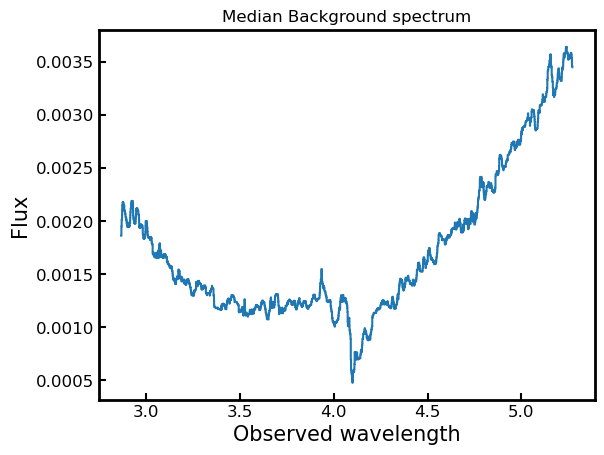

In [4]:
mask_bkg = IFU.sp.QFitsview_mask(PATH+'COS30_IFS/Data/R2700_bkg.fits') # Loading background mask
Cube.background_sub_spec(center= [50,50], manual_mask=mask_bkg, plot=1) # Doing background subtraction

plt.show()

## Saving the class and resume

At any point you can save the Cube class with save(file_path) function. Later on you can Initialize the empty class again and then load it with load(file_path)

In [3]:
Cube.save('/Users/jansen/Test.txt') # 

Cube2 = IFU.Cube()
Cube2.load('/Users/jansen/Test.txt')


# Extracting your first spectrum

In order to extract a specturm we first collpase the cube into a white light image using collpase_white function. Then we find the center of the galaxy from the continuum. With KMOS or seeing limited SINFONI observations, we could use 2D Gaussian in order to find the center of an object. With NIRSpec and SINFONI AO, galaxies can be quite clumy and hence it often fails. Therefore I would suggest using the manual= [x,y] keyword in order to define it yourself. 

Next we select and collapse the aperture using the D1_spectra_collapse with he following keywords:
1) radius of the extraction circle (units of arcseconds)
2) add_save = string - name appended to the basic file name when saving the spectrum
3) err_range - list of 2 or 4 numbers. This are wavelength boundries used (read full explanation below)
4) boundary - if you use 4 numbers in err_range, boundary will be where the error calc will be split.
5) plot_err = 1/0 - do you want to plot the comparison of the errors estimated in this code and the ones from the NIRSpec extension 

For NIRSpec spectra:
Unfortunately, we cannot use the error extension from the pipeline as there is scaling issue at hand. However, the error extension maintains all of the correlation between channels. Because of that, we estimate the error from the error extension and then compared to the median value of this error array to the standard deviation of the continuum. The err_range values are defining the wavelength region that is used to estimate the standard deviation of the spectrum. There are two options of supplying the right info:

a) err_range = [lower, upper] - in this case yo the upper and lower wavelength range of emission line free part of the spectrum. The code will estimate the standard deviation of that part to the error extension and scale it. 

b) err_range = [lower_a, upper_a, lower_b, upper_b] and boundary=4.1 - in this case yo the upper and lower wavelength range of TWO seperate emission line free sections of the spectrum. The code will estimate the standard deviation of that part to the error extension and scale it for each section. The boundary value is the wavelength value where you apply the the lower or upper scaling factor. Example below:

err_range=[3.95,4.05, 5,5.1] and boundary=4.1

The code will estimate the standard deviation from the spectrum and hence the scaling factor for two section:
3.95-4.05 and  5.-5.1. It will then applying the two scaling factor to error extension with lambda<4.1 and lambda>4.1. 

So the err_range should be section of spectra without any emission lines. The boundary should be somewhere between emission lines of interest of in case of R2700 - the detector gap



Center of cont [59. 50.]
Extracting spectrum from diameter 0.4 arcseconds
Pixel scale: 20.0
radius  4.0
NIRSPEC mode of error calc
Error rescales are:  3.868152344643509 3.784342499812698


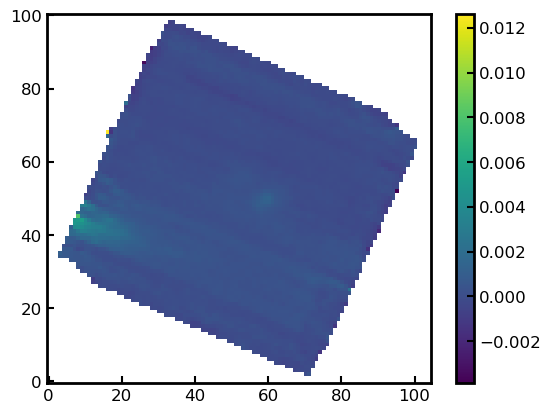

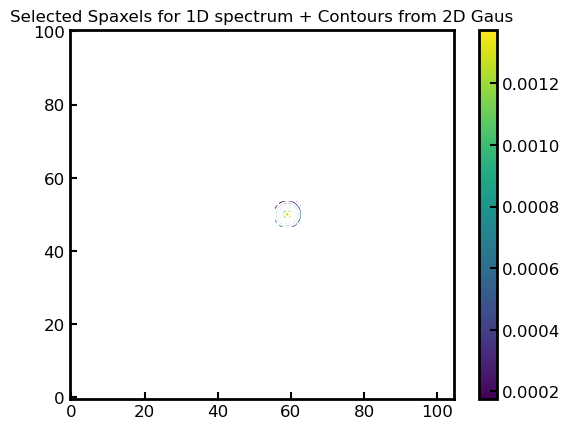

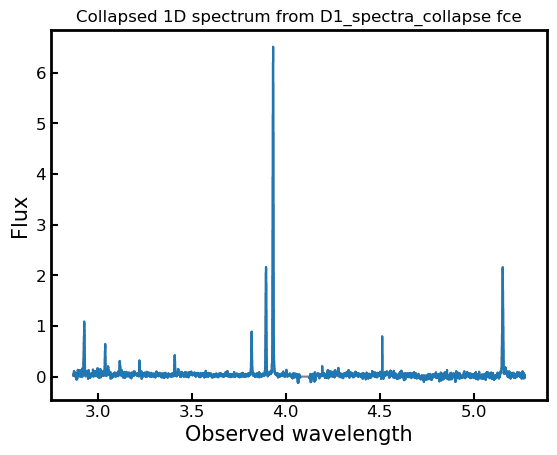

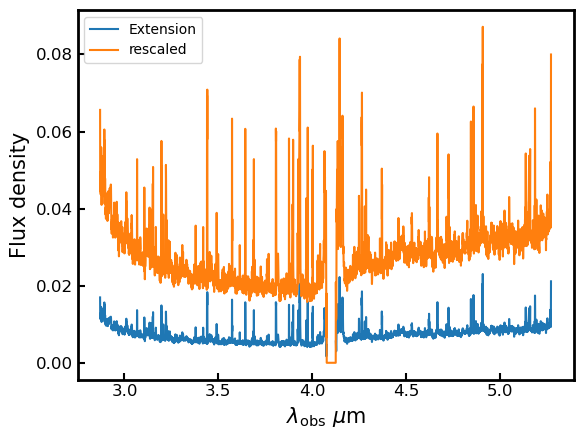

In [28]:
Cube.collapse_white(1)

Cube.find_center(1, manual=[59,50])
Cube.D1_spectra_collapse(1, addsave='',rad=0.2, err_range=[3.95,4.05, 5,5.1], boundary=4.1, plot_err=1)
plt.show()





## Plotting spectrum

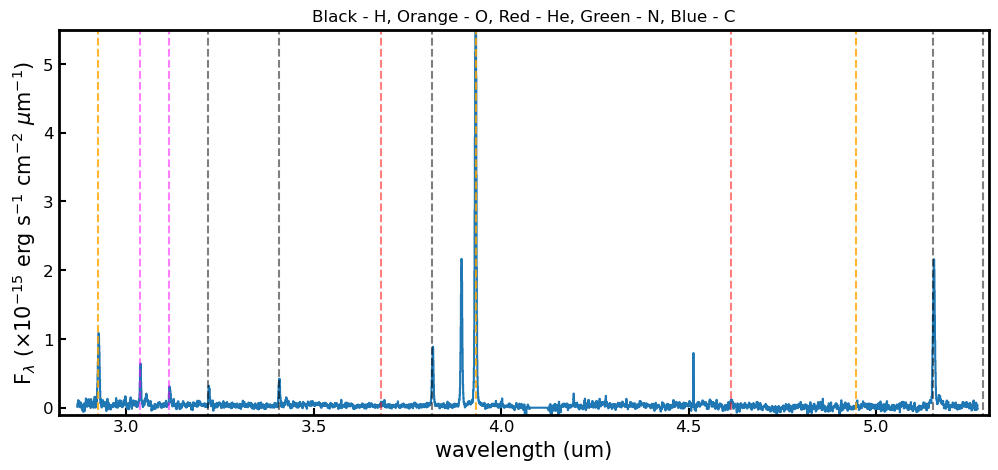

In [30]:
f, ax = plt.subplots(1, figsize=(12,5))

ax.plot(Cube.obs_wave, Cube.D1_spectrum, drawstyle='steps-mid')

ylow = -0.2
yhig = 10

ax.vlines(0.5008*(1+Cube.z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)
ax.vlines(0.3727*(1+Cube.z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)
ax.vlines(0.6300*(1+Cube.z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)


ax.vlines(0.6563*(1+Cube.z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+Cube.z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4340*(1+Cube.z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4100*(1+Cube.z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.1215*(1+Cube.z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+Cube.z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.3869*(1+Cube.z),ylow,yhig, linestyle='dashed',color='magenta', alpha=0.5)
ax.vlines(0.3968*(1+Cube.z),ylow,yhig, linestyle='dashed',color='magenta', alpha=0.5)
ax.vlines(0.2424*(1+Cube.z),ylow,yhig, linestyle='dashed',color='magenta', alpha=0.5)


ax.vlines(0.4686*(1+Cube.z),ylow,yhig, linestyle='dashed',color='red', alpha=0.5)
ax.vlines(0.5877*(1+Cube.z),ylow,yhig, linestyle='dashed',color='red', alpha=0.5)

ax.set_title('Black - H, Orange - O, Red - He, Green - N, Blue - C')

ax.set_xlabel('wavelength (um)')
ax.set_ylabel(r'F$_\lambda$ ($\times 10^{-15}$ erg s$^{-1}$ cm$^{-2}$ $\mu$m$^{-1}$)')

ax.set_xlim(2.82, 5.3)
ax.set_ylim(-0.1, 5.5)
plt.show()

## Simple fit

### Fitting Halpha only

models - BLR, Outflow, Single_only, Outflow_only, BLT_only, QSO_BKPL

In [ ]:
# B14 style
Cube.fitting_collapse_Halpha(models='Outflow', plot=1)
plt.show()

### Fitting [OIII]

models - Single_only, Outflow_only, BLR, BLR_simple
simple = 0 or 1 when 1, I tie the Hbeta and OIII kinematics together

100%|██████████| 6000/6000 [00:29<00:00, 200.76it/s]


Delta BIC -226.51731783993273  
BICM 706.793805776977
['name', 'z', 'cont', 'cont_grad', 'OIII_peak', 'OIII_out_peak', 'Nar_fwhm', 'outflow_fwhm', 'outflow_vel', 'Hbeta_peak', 'Hbeta_out_peak', 'popt']
169.60774858353653
48.40177423817615


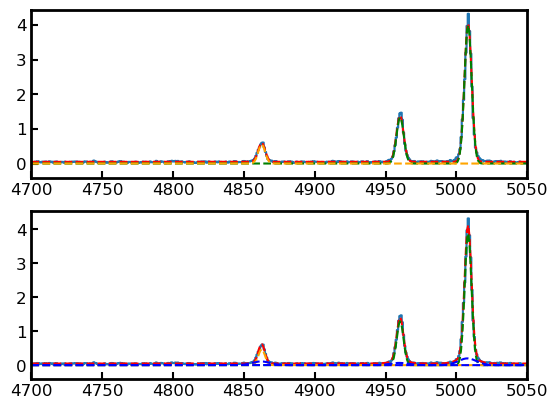

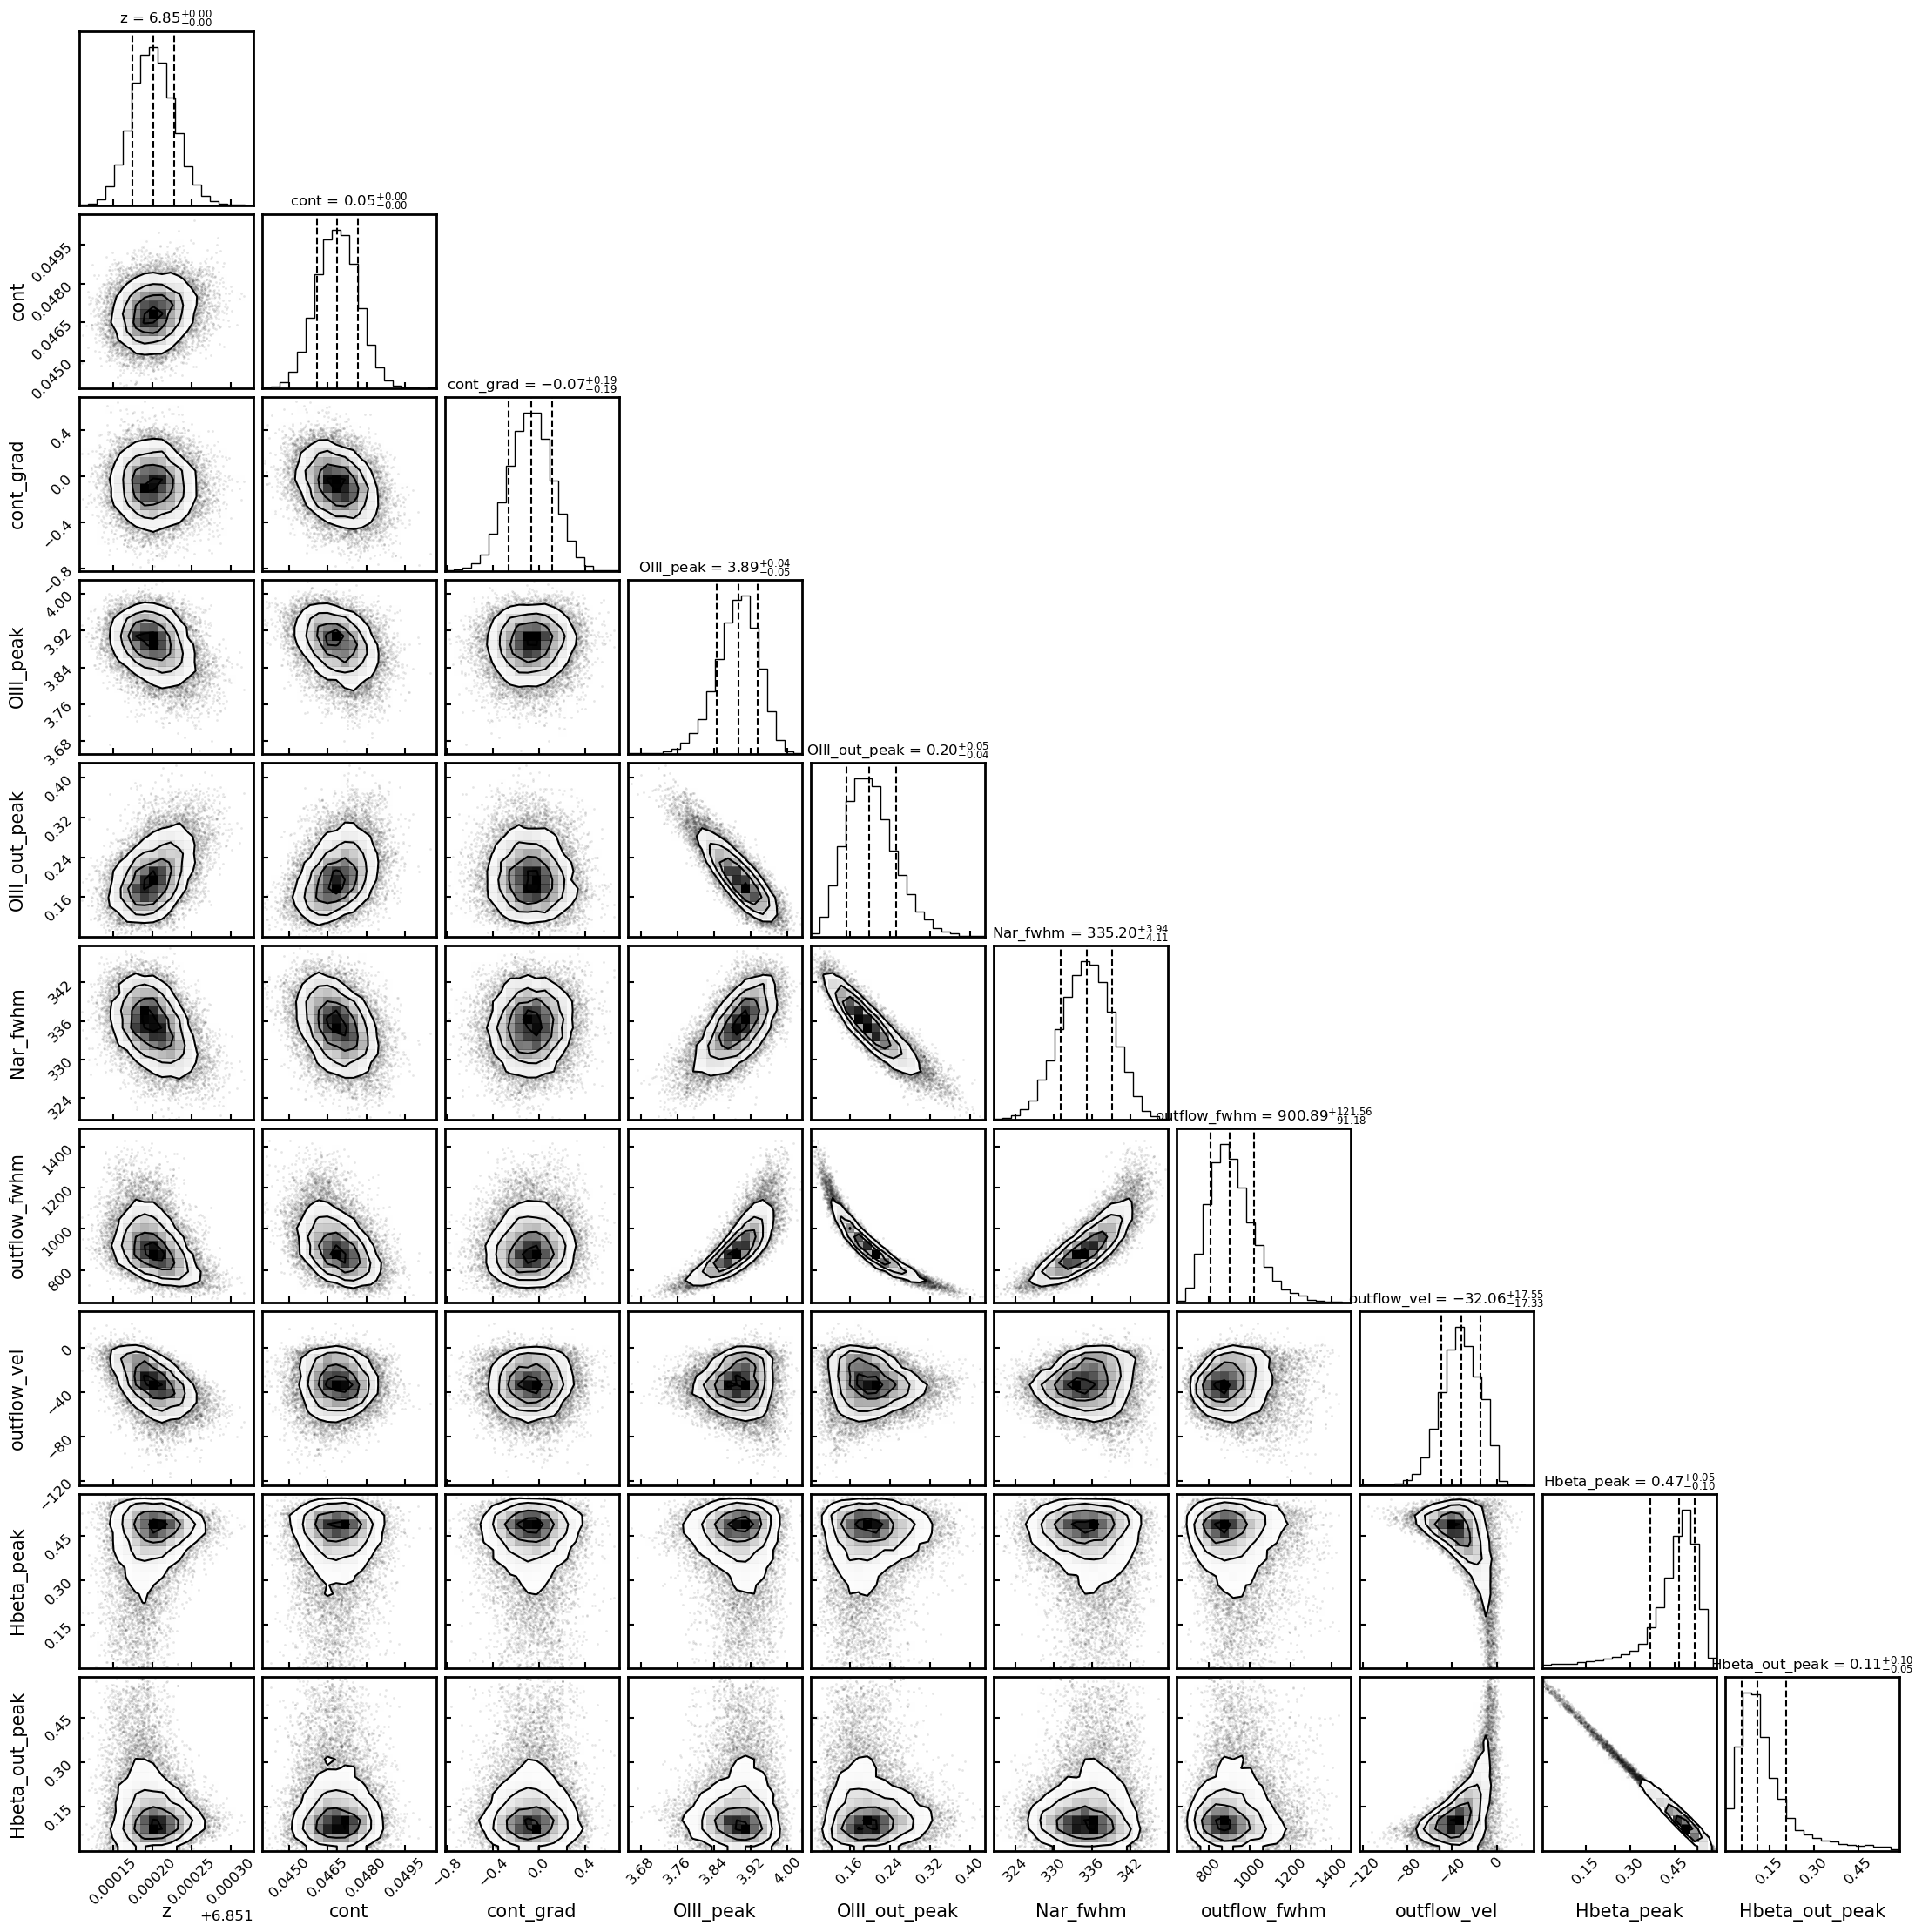

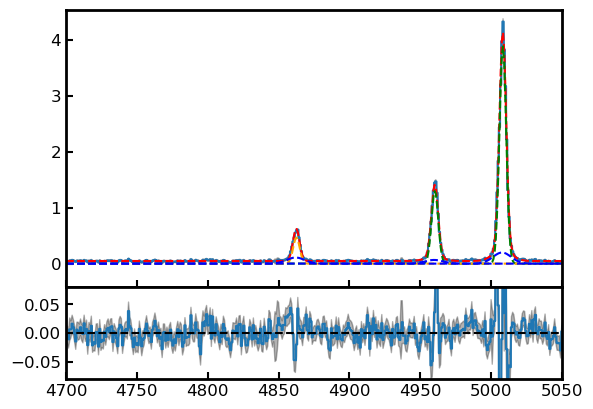

In [6]:
# B14 style
Cube.fitting_collapse_OIII(models='Outflow',simple=1, plot=1)
plt.show()

### Fitting Halpha + [OIII]

models - Single_only, Outflow_only, BLR, QSO_BKPL, BLR_simple

100%|██████████| 6000/6000 [00:36<00:00, 164.36it/s]


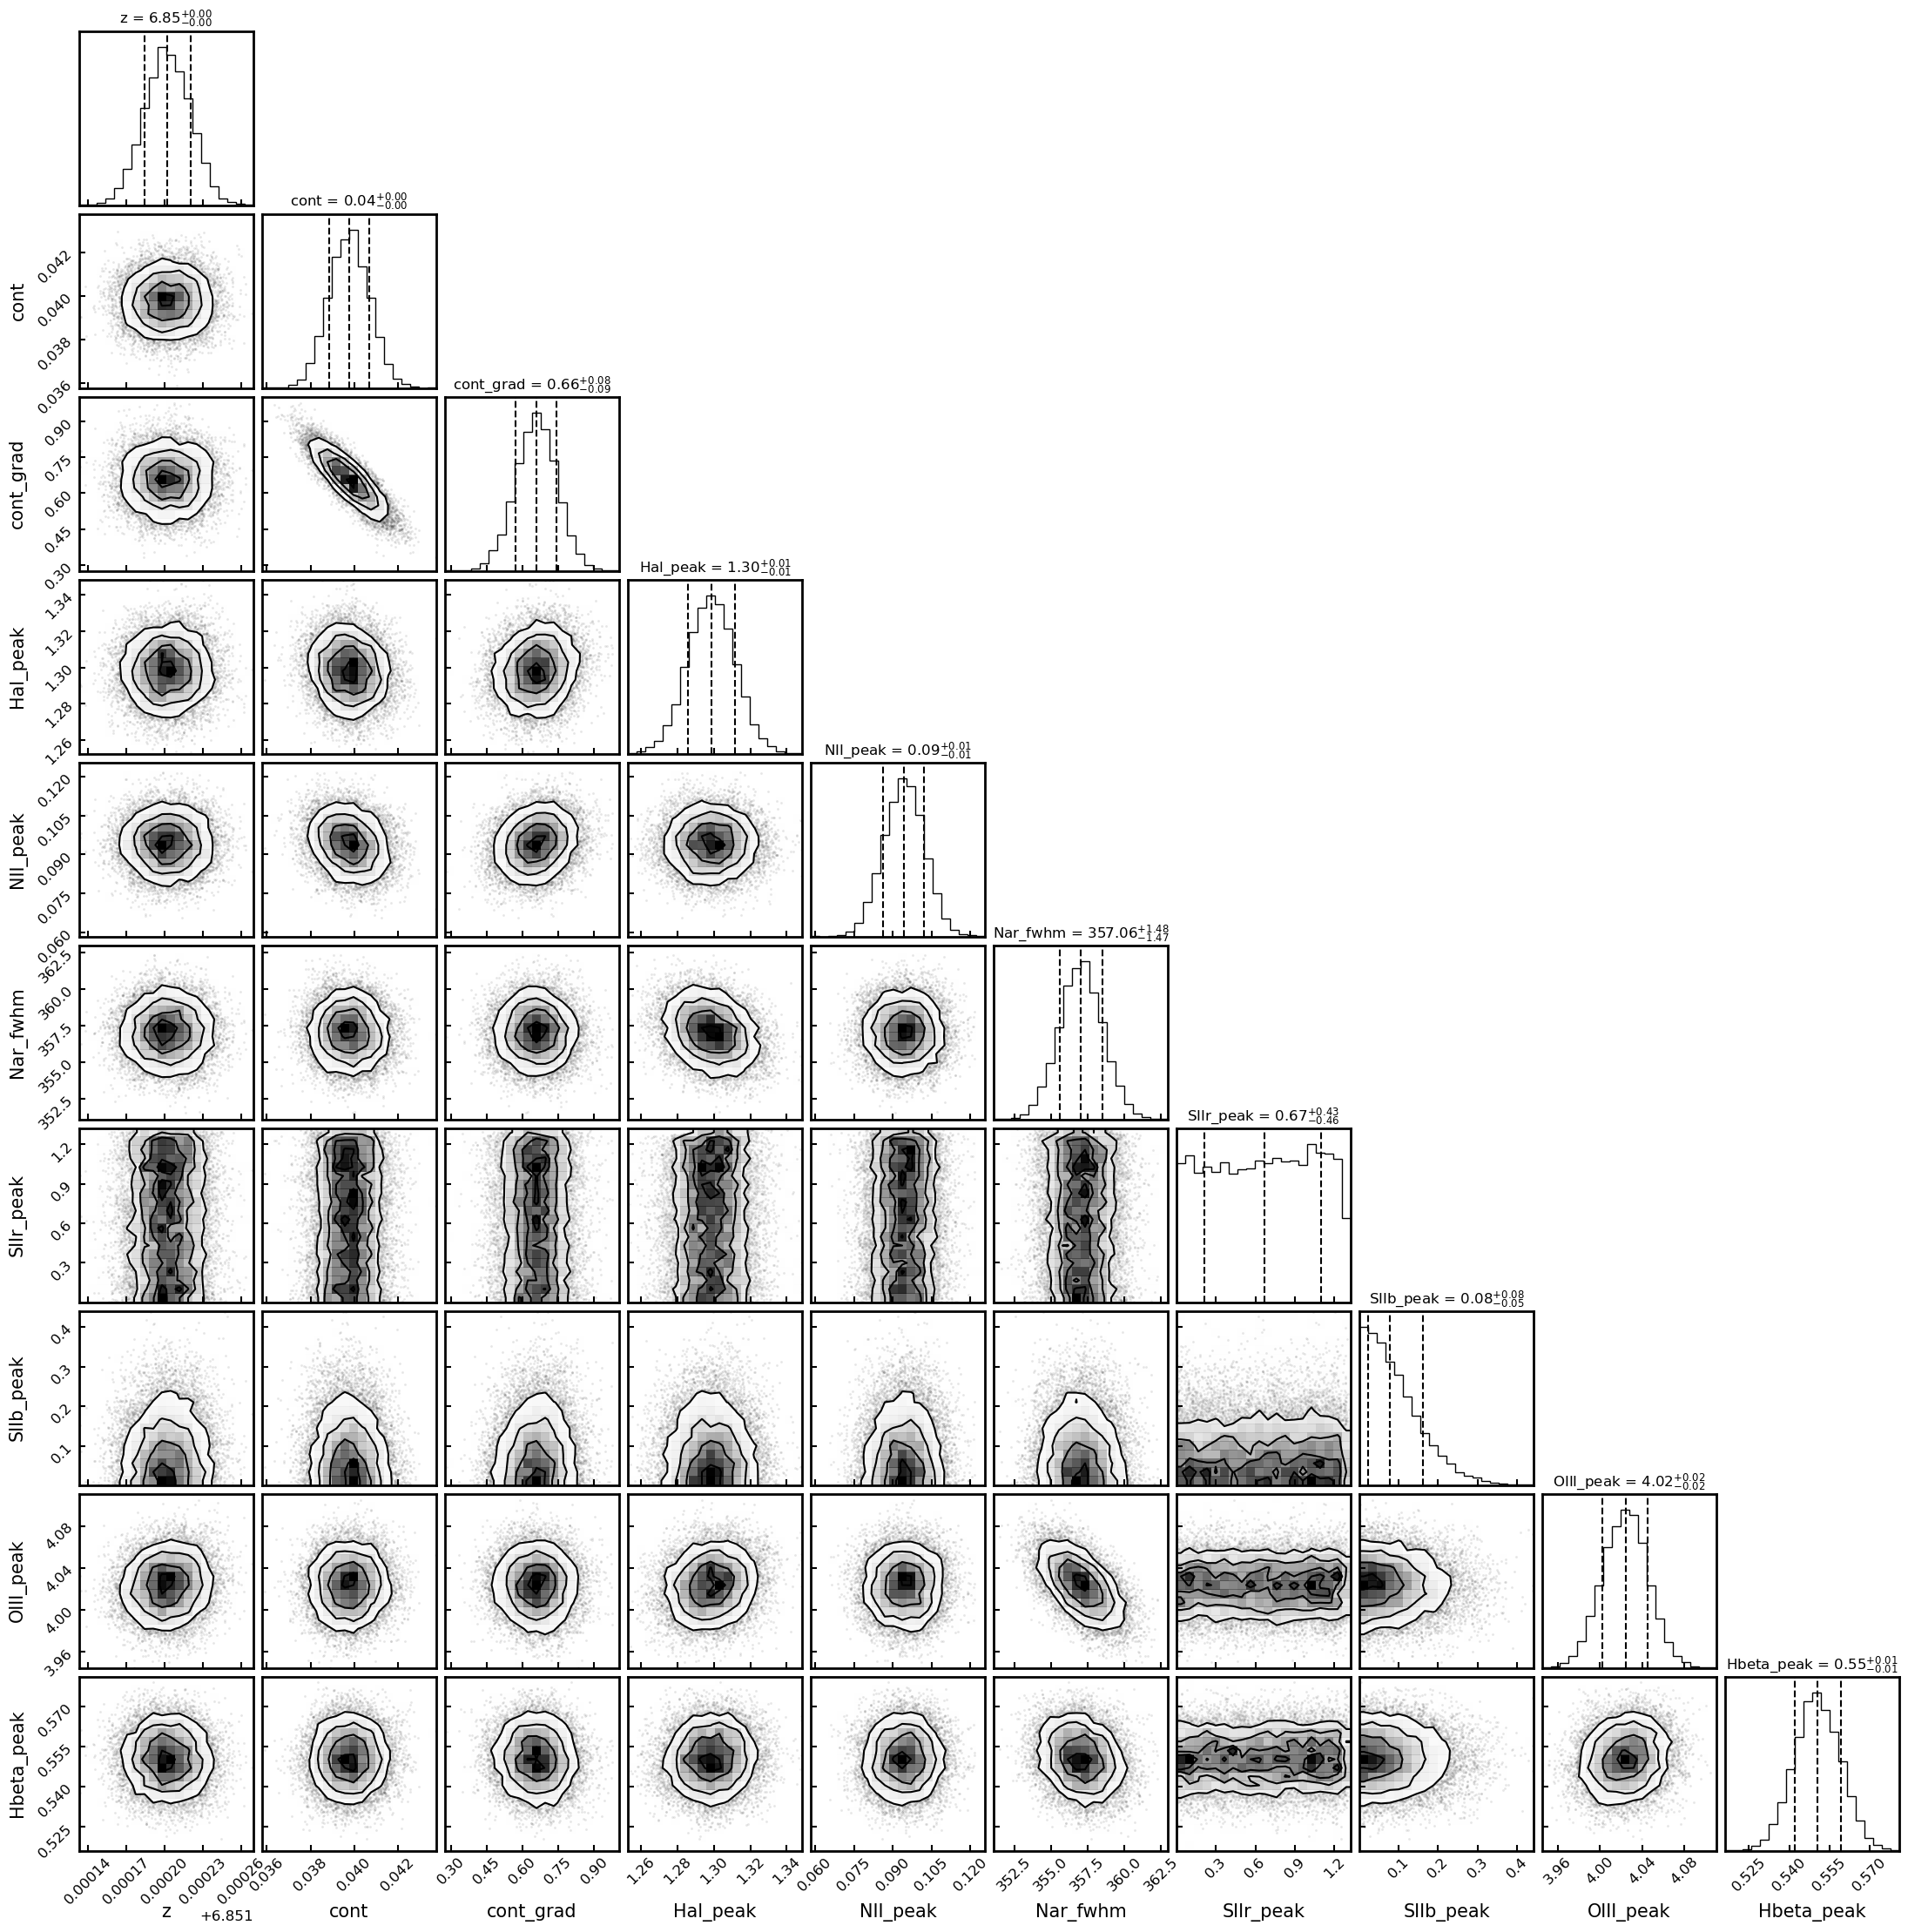

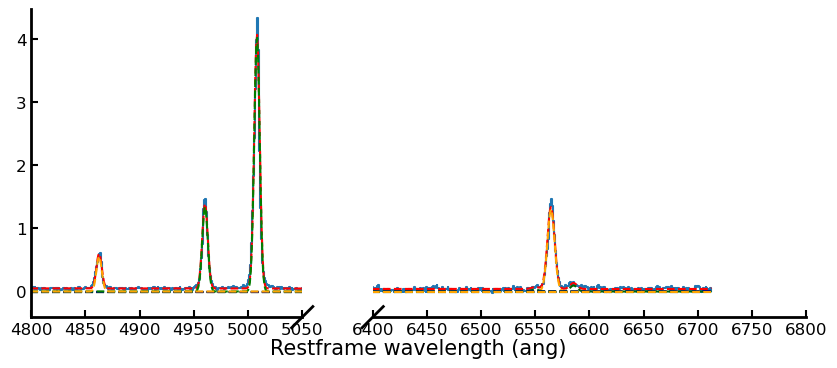

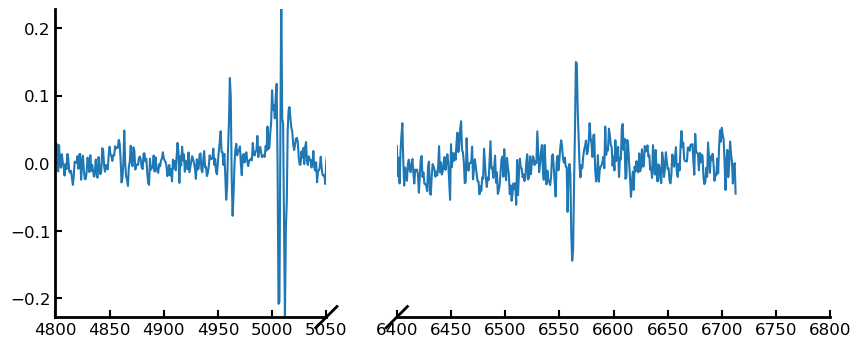

In [5]:
Cube.z = 6.85133785
Cube.fitting_collapse_Halpha_OIII(models='Single_only', plot=1)

plt.show()

In [38]:
Cube.D1_fit_results

{'name': 'Halpha_OIII',
 'z': array([6.85120230e+00, 1.83342092e-05, 1.86347706e-05]),
 'cont': array([0.03973729, 0.00095058, 0.00094403]),
 'cont_grad': array([0.66030846, 0.0911194 , 0.0911465 ]),
 'Hal_peak': array([1.29842943, 0.01305306, 0.01235988]),
 'NII_peak': array([0.09445533, 0.00770528, 0.00790434]),
 'Nar_fwhm': array([357.00919868,   1.44192874,   1.44124844]),
 'SIIr_peak': array([0.65038992, 0.44648393, 0.44352878]),
 'SIIb_peak': array([0.07651981, 0.05404456, 0.08676291]),
 'OIII_peak': array([4.02341117, 0.02118929, 0.02208698]),
 'Hbeta_peak': array([0.54998893, 0.00829492, 0.00886285]),
 'popt': [6.8512022971611755,
  0.03973729247707291,
  0.6603084576344752,
  1.2984294307596067,
  0.09445533108662069,
  357.0091986775983,
  0.6503899205740085,
  0.07651980604563278,
  4.023411166974268,
  0.5499889338662215]}

In [7]:
print(IFU.sp.flux_calc_mcmc( Cube.D1_fit_results,Cube.D1_fit_chain, 'OIIIt', Cube.flux_norm ))


(2.7599714000369688e-17, 1.551843768273226e-19, 1.564434631145833e-19)


## Fitting Custom Function

In [15]:
def gauss(x, k, mu,sig):

    expo= -((x-mu)**2)/(2*sig*sig)

    y= k* e**expo

    return y
from astropy.modeling.powerlaws import PowerLaw1D

def Full_optical(x, z, cont,cont_grad,  Hal_peak, NII_peak, OIIIn_peak, Hbeta_peak, Hgamma_peak, Hdelta_peak, NeIII_peak, OII_peak, OII_rat,OIIIc_peak, HeI_peak,HeII_peak, Nar_fwhm):
    # Halpha side of things
    Hal_wv = 6564.52*(1+z)/1e4
    NII_r = 6585.27*(1+z)/1e4
    NII_b = 6549.86*(1+z)/1e4
    
    OIIIr = 5008.24*(1+z)/1e4
    OIIIb = 4960.3*(1+z)/1e4
    Hbeta = 4862.6*(1+z)/1e4

    Hal_nar = gauss(x, Hal_peak, Hal_wv, Nar_fwhm/3e5*Hal_wv/2.35482)
    NII_nar_r = gauss(x, NII_peak, NII_r, Nar_fwhm/3e5*NII_r/2.35482)
    NII_nar_b = gauss(x, NII_peak/3, NII_b, Nar_fwhm/3e5*NII_b/2.35482)
    
    Hgamma_wv = 4341.647191*(1+z)/1e4
    Hdelta_wv = 4102.859855*(1+z)/1e4
    
    Hgamma_nar = gauss(x, Hgamma_peak, Hgamma_wv, Nar_fwhm/3e5*Hgamma_wv/2.35482)
    Hdelta_nar = gauss(x, Hdelta_peak, Hdelta_wv, Nar_fwhm/3e5*Hdelta_wv/2.35482)
    
    
    # [OIII] side of things
    OIIIr = 5008.24*(1+z)/1e4
    OIIIb = 4960.3*(1+z)/1e4
    Hbeta = 4862.6*(1+z)/1e4

    OIII_nar = gauss(x, OIIIn_peak, OIIIr, Nar_fwhm/3e5*OIIIr/2.35482) + gauss(x, OIIIn_peak/3, OIIIb, Nar_fwhm/3e5*OIIIr/2.35482)
    Hbeta_nar = gauss(x, Hbeta_peak, Hbeta, Nar_fwhm/3e5*Hbeta/2.35482)
    
    NeIII = gauss(x, NeIII_peak, 3869.68*(1+z)/1e4, Nar_fwhm/3e5*(3869.68*(1+z)/1e4)/2.35482 ) + gauss(x, 0.322*NeIII_peak, 3968.68*(1+z)/1e4, Nar_fwhm/3e5*(3968.68*(1+z)/1e4)/2.35482 )
    
    OII = gauss(x, OII_peak, 3727.1*(1+z)/1e4, Nar_fwhm/3e5*(3727.1*(1+z)/1e4)/2.35482 )  + gauss(x, OII_rat*OII_peak, 3729.875*(1+z)/1e4, Nar_fwhm/3e5*(3729.875*(1+z)/1e4)/2.35482 ) 
    
    OIIIc = gauss(x, OIIIc_peak, 4364.436*(1+z)/1e4, Nar_fwhm/3e5*(4364.436*(1+z)/1e4)/2.35482 )
    HeI = gauss(x, HeI_peak, 3889.73*(1+z)/1e4, Nar_fwhm/3e5*(3889.73*(1+z)/1e4)/2.35482 )
    HeII = gauss(x, HeII_peak, 4686.0*(1+z)/1e4, Nar_fwhm/3e5*(4686.0*(1+z)/1e4)/2.35482 )

    contm = PowerLaw1D.evaluate(x, cont,Hal_wv, alpha=cont_grad)

    return contm+Hal_nar+NII_nar_r+NII_nar_b + OIII_nar + Hbeta_nar + Hgamma_nar + Hdelta_nar + NeIII+ OII + OIIIc+ HeI+HeII


In [16]:
priors={'z':[Cube.z,'normal_hat', Cube.z, 0.001, Cube.z-0.05, Cube.z+0.05]}
priors['cont']=[0.1,'loguniform', -3,1]
priors['cont_grad']=[0.2,'normal', 0,0.2]
priors['Hal_peak']=[5.,'loguniform', -3,1]
priors['NII_peak']=[0.4,'loguniform', -3,1]
priors['Nar_fwhm']=[300,'uniform', 200,900]
priors['OIII_peak']=[6.,'loguniform', -3,1]
priors['OI_peak']=[1.,'loguniform', -3,1]
priors['HeI_peak']=[1.,'loguniform', -3,1]
priors['HeII_peak']=[1.,'loguniform', -3,1]
priors['Hbeta_peak']=[2,'loguniform', -3,1]
priors['Hgamma_peak'] = [1.,'loguniform',-3,1]
priors['Hdelta_peak'] = [0.5,'loguniform',-3,1]
priors['NeIII_peak'] = [0.3,'loguniform',-3,1]
priors['OII_peak'] = [0.4,'loguniform',-3,1]
priors['OII_rat']=[1,'uniform', 0.2,4]
priors['OIIIc_peak']=[0.2,'loguniform', -3,1]

labels= ['z', 'cont','cont_grad',  'Hal_peak', 'NII_peak', 'OIII_peak', 'Hbeta_peak','Hgamma_peak', 'Hdelta_peak','NeIII_peak','OII_peak','OII_rat','OIIIc_peak', 'HeI_peak','HeII_peak', 'Nar_fwhm']

use = np.where( ( (Cube.obs_wave> 2.82) | (Cube.obs_wave<3.46) ) & ( (Cube.obs_wave>3.75) | (Cube.obs_wave<4.1) ) & ( (Cube.obs_wave>5) | (Cube.obs_wave<5.3) ) )[0]

optical = emfit.Fitting(Cube.obs_wave, Cube.D1_spectrum, Cube.D1_spectrum_er,Cube.z, priors=priors, N=5000) # Cube.obs_wave[use], Cube.D1_spectrum[use], Cube.D1_spectrum_er[use]
optical.fitting_general( Full_optical, labels, emfit.logprior_general_scipy)
    


100%|██████████| 5000/5000 [02:50<00:00, 29.29it/s]


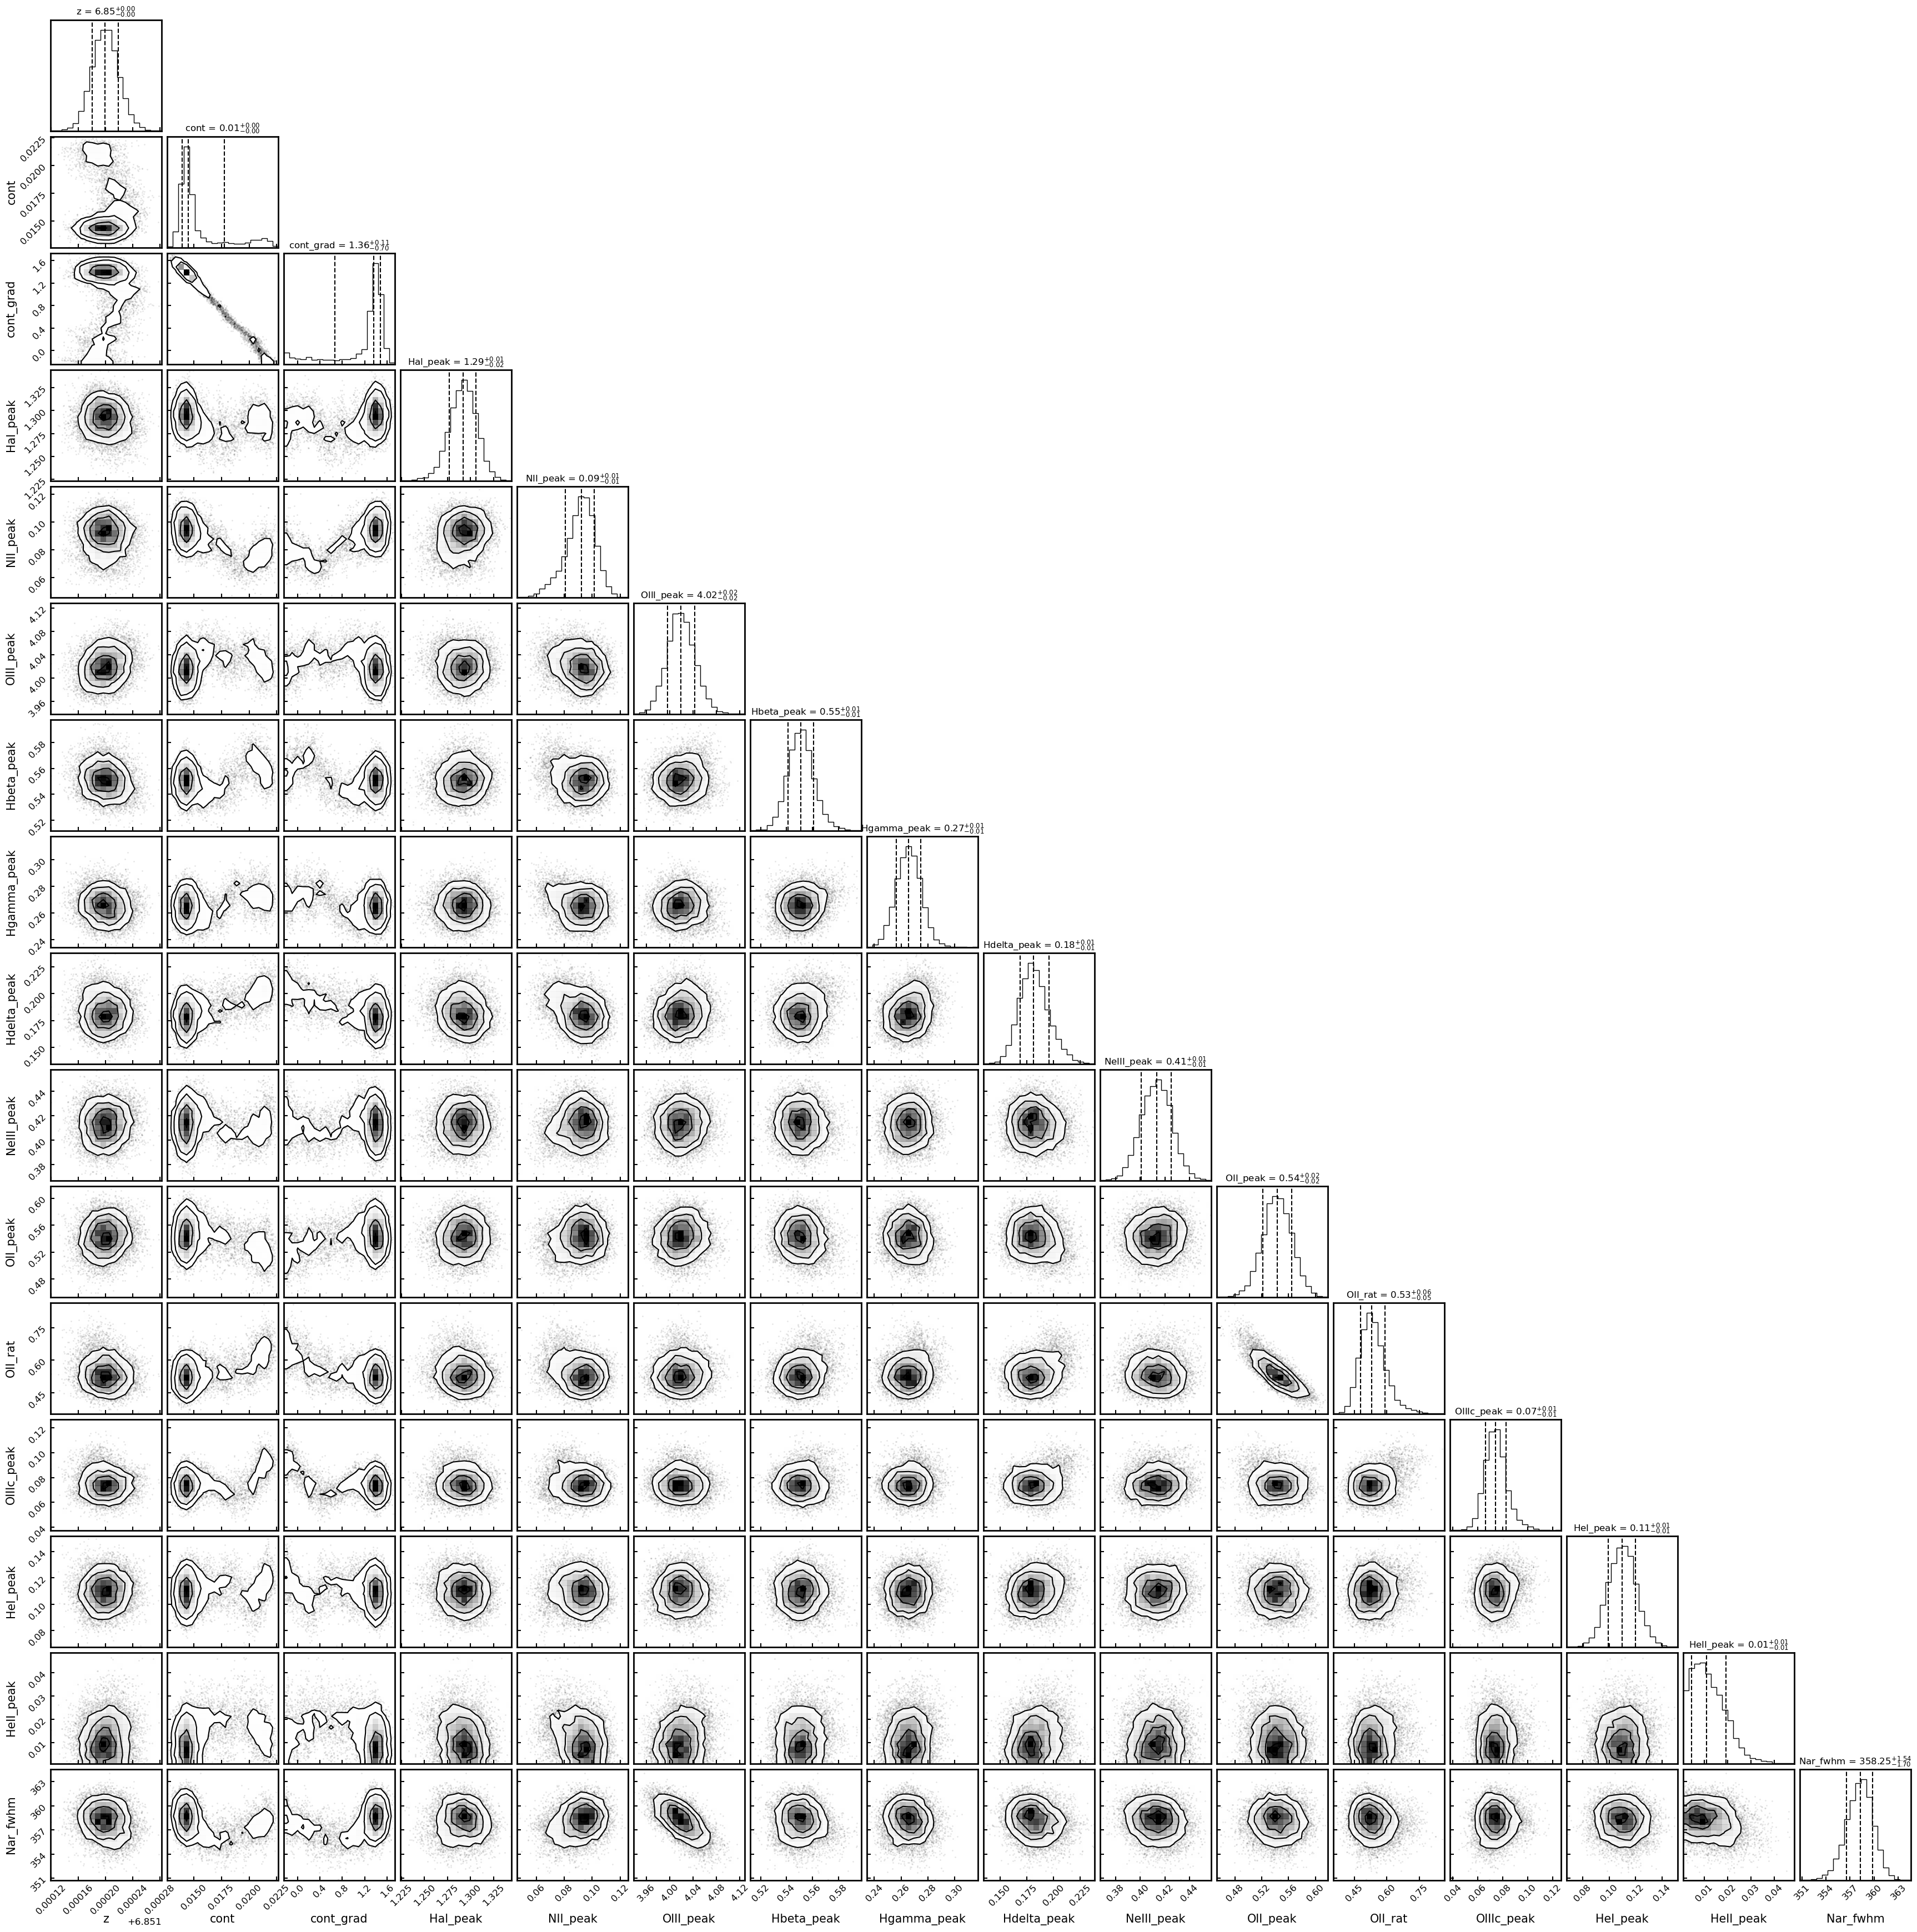

In [17]:
import corner

fig = corner.corner(
            IFU.sp.unwrap_chain(optical.chains), 
            labels = labels,
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True,
            title_kwargs={"fontsize": 12})
fig.savefig('/Users/jansen/corner_full.pdf')
plt.show()

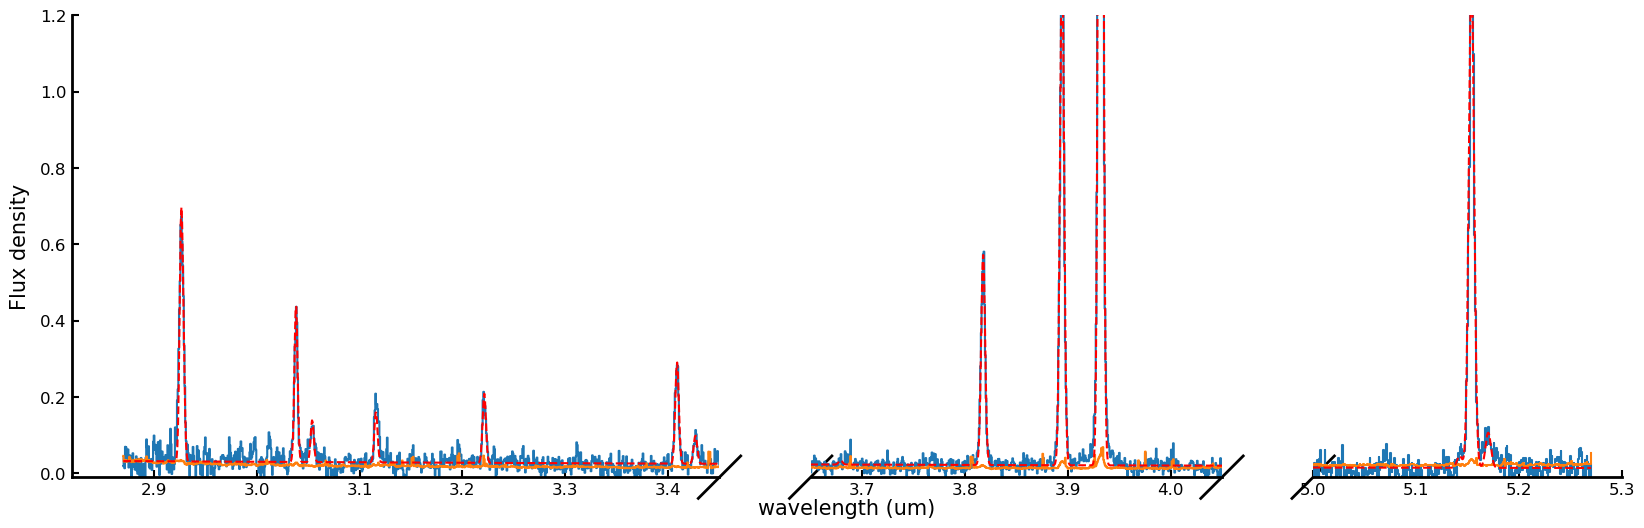

In [18]:
f = plt.figure( figsize=(20,6))
from brokenaxes import brokenaxes
ax = brokenaxes(xlims=((2.820,3.45),(3.65,4.05),(5.0,5.3)),  hspace=.01)

ax.plot(Cube.obs_wave, Cube.D1_spectrum, drawstyle='steps-mid')
ax.plot(Cube.obs_wave, Cube.D1_spectrum_er, drawstyle='steps-mid')

ax.plot(Cube.obs_wave, Full_optical(Cube.obs_wave, *optical.props['popt']), 'r--')

ax.set_xlabel('wavelength (um)')
ax.set_ylabel('Flux density')

ax.set_ylim(-0.01, 1.2)

plt.show()

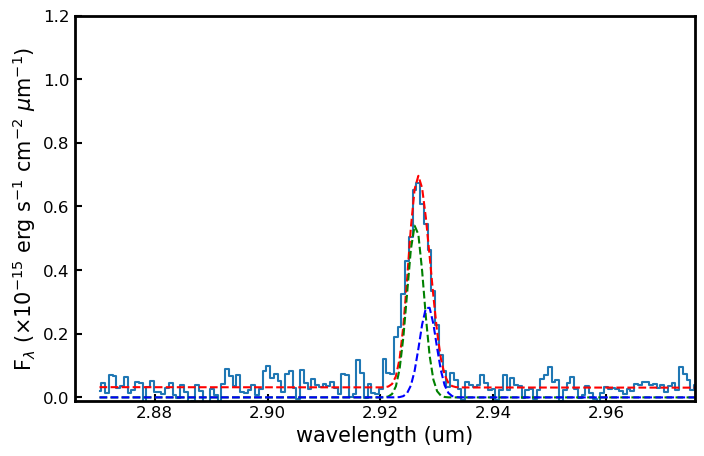

In [19]:
f,ax= plt.subplots(1, figsize=(8,5))

ax.plot(Cube.obs_wave, Cube.D1_spectrum, drawstyle='steps-mid')
ax.plot(Cube.obs_wave, Full_optical(Cube.obs_wave, *optical.props['popt']), 'r--')

OII_peak = optical.props['OII_peak'][0]
OII_rat = optical.props['OII_rat'][0]
zoii=optical.props['z'][0]
sigma_oii = optical.props['Nar_fwhm'][0]/3e5*(3727.1*(1+zoii)/1e4)/2.35482

OII3727 = gauss(Cube.obs_wave, OII_peak, 3727.1*(1+zoii)/1e4, sigma_oii )  
OII3729 = gauss(Cube.obs_wave, OII_rat*OII_peak, 3729.875*(1+zoii)/1e4, sigma_oii ) 

ax.plot(Cube.obs_wave, OII3727, 'g--')
ax.plot(Cube.obs_wave, OII3729, 'b--')


ax.set_xlim(3650.1*(1+zoii)/1e4, 3790.1*(1+zoii)/1e4)

ax.set_xlabel('wavelength (um)')
ax.set_ylabel(r'F$_\lambda$ ($\times 10^{-15}$ erg s$^{-1}$ cm$^{-2}$ $\mu$m$^{-1}$)')

ax.set_ylim(-0.01, 1.2)

plt.show()

### Flux Calc

In [20]:
print('[OIII] flux from custom', IFU.sp.flux_calc_mcmc(optical.props,optical.chains, 'general', Cube.flux_norm, wv_cent=5008, peak_name='OIII_peak', fwhm_name='Nar_fwhm' ))
print('Hbeta flux from custom', IFU.sp.flux_calc_mcmc(optical.props,optical.chains, 'general', Cube.flux_norm, wv_cent=4861, peak_name='Hbeta_peak', fwhm_name='Nar_fwhm' ))
print('[NII] flux from custom',IFU.sp.flux_calc_mcmc(optical.props,optical.chains, 'general', Cube.flux_norm, wv_cent=6587, peak_name='NII_peak', fwhm_name='Nar_fwhm' ))
print('Halpha flux from custom',IFU.sp.flux_calc_mcmc(optical.props,optical.chains, 'general', Cube.flux_norm, wv_cent=6563, peak_name='Hal_peak', fwhm_name='Nar_fwhm' ))

(2.0086848521276342e-17, 8.782224880348053e-20, 9.224243884723938e-20)


# Regional Spectra

In [ ]:
from brokenaxes import brokenaxes
mask= IFU.sp.QFitsview_mask(PATH+'COS30_IFS/Data/R2700_main.fits')

Flux_main, Flux_er_main, mask_main = Cube.Regional_Spec(center=[19,24],manual_mask=mask, rad=0.3,err_range=[3.95,4.05, 5,5.1], boundary=4.1)

#Flux_er_main[np.where(Flux_er_main==0)[0]]=1
#use = np.where( ( (Cube.obs_wave> 2.82) | (Cube.obs_wave<3.46) ) & ( (Cube.obs_wave>3.75) | (Cube.obs_wave<4.1) ) & ( (Cube.obs_wave>5) | (Cube.obs_wave<5.3) ) )[0]

optical_main = emfit.Fitting(Cube.obs_wave, Flux_main, Flux_er_main,Cube.z, priors=priors, N=5000)
optical_main.fitting_general( Full_optical, labels, emfit.logprior_general)

sol = optical_main.props
fitted_model = Full_optical


In [ ]:
f = plt.figure( figsize=(20,6))
from brokenaxes import brokenaxes
ax = brokenaxes(xlims=((2.820,3.45),(3.75,4.05),(5,5.3)),  hspace=.01)

ax.plot(Cube.obs_wave, Flux_main, drawstyle='steps-mid')
ax.plot(Cube.obs_wave, Full_optical(Cube.obs_wave, *optical_main.props['popt']), 'r--')

ax.set_xlabel('wavelength (um)')
ax.set_ylabel('Flux density')

ax.set_ylim(-0.01, 1.2)

f,ax =plt.subplots(1)
ax.imshow(Cube.Median_stack_white, origin='lower',vmin=Cube.Median_stack_white.max()*0.01, vmax=Cube.Median_stack_white.max()*0.2)
mask_plot = mask_main[0,:,:].copy()
mask_plot[mask_plot==True] = 1
mask_plot[mask_plot==False]= 0
ax.contour(mask_plot, colors='red', linewidths=1.0, levels=(0.))

mask_comp = mask_plot.copy()

sol['Flux_Halpha'] = IFU.sp.flux_calc_mcmc(optical_main.props,optical_main.chains, 'Han', Cube.flux_norm)
sol['Flux_NII'] = IFU.sp.flux_calc_mcmc(optical_main.props,optical_main.chains, 'NII', Cube.flux_norm)
sol['Flux_OIII'] = IFU.sp.flux_calc_mcmc(optical_main.props, optical_main.chains, 'OIIIt', Cube.flux_norm)
sol['Flux_Hb'] = IFU.sp.flux_calc_mcmc(optical_main.props,optical_main.chains, 'Hbeta', Cube.flux_norm)

print(sol)
print('Flux Halpha ', sol['Flux_Halpha'])
print('Flux NII ', sol['Flux_NII'])
print('Flux OIII ', sol['Flux_OIII'])
print('Flux hbeta', sol['Flux_Hb'])

plt.show()

# Spaxel by Spaxel fitting

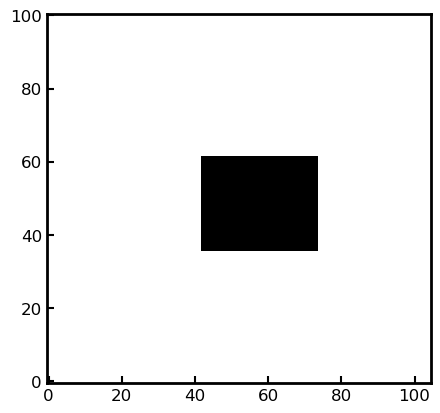

In [20]:
mask = IFU.sp.QFitsview_mask(PATH+'COS30_IFS/Data/R2700_source_mask.fits')

plt.figure()
plt.imshow(mask, cmap='gray', origin='lower')
plt.show()

## Unwrapping

6.000000000000038


100%|██████████| 101/101 [16:07<00:00,  9.58s/it]

832


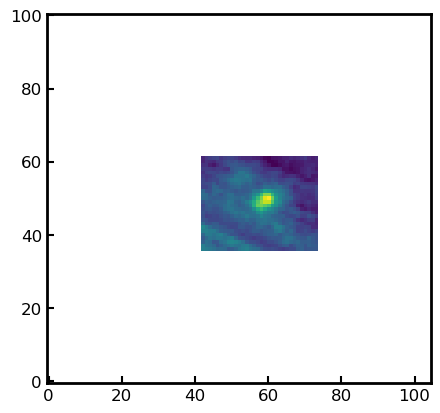

In [29]:
Unwrapping = False
if Unwrapping==True:
    Cube.unwrap_cube(rad=0.3, instrument='NIRSPEC05',mask_manual=mask, err_range=[3.95,4.05, 5,5.1], boundary=4.1, add='') 
plt.show()

In [21]:
priors={'z':[Cube.z,'normal_hat', Cube.z, 0.001, Cube.z-0.05, Cube.z+0.05]}
priors['cont']=[0.001,'loguniform', -4,1]
priors['cont_grad']=[0.1,'normal', 0,0.2]
priors['Hal_peak']=[0.1,'loguniform', -4,1]
priors['NII_peak']=[0.4,'loguniform', -4,1]
priors['Nar_fwhm']=[300,'uniform', 200,900]
priors['OIII_peak']=[0.1,'loguniform', -4,1]
priors['OI_peak']=[0.01,'loguniform', -4,1]
priors['HeI_peak']=[0.01,'loguniform', -4,1]
priors['Hbeta_peak']=[0.02,'loguniform', -4,1]
priors['Hgamma_peak'] = [0.02,'loguniform',-4,1]
priors['Hdelta_peak'] = [0.01,'loguniform',-4,1]
priors['NeIII_peak'] = [0.01,'loguniform',-4,1]
priors['OII_peak'] = [0.01,'loguniform',-4,1]
priors['OII_rat']=[1,'uniform', 0.2,4]
priors['OIIIc_peak']=[0.01,'loguniform', -4,1]

Spaxel = False
if Spaxel==True: 
    if __name__ == '__main__':
        Cube.Spaxel_fitting_general_MCMC_mp(Full_optical,labels, priors, emfit.logprior_general_scipy, add='')


import of the unwrap cube - done


100%|██████████| 9/9 [11:11<00:00, 74.64s/it] 

--- Cube fitted in 671.8387620449066 seconds ---


### Generating the maps

In [73]:
def Full_optical_old(x, z, cont,cont_grad,  Hal_peak, NII_peak, OIIIn_peak, Hbeta_peak, Hgamma_peak, Hdelta_peak, NeIII_peak, OII_peak, OII_rat,OIIIc_peak, HeI_peak,Nar_fwhm):
    # Halpha side of things
    Hal_wv = 6564.52*(1+z)/1e4
    NII_r = 6585.27*(1+z)/1e4
    NII_b = 6549.86*(1+z)/1e4
    
    OIIIr = 5008.24*(1+z)/1e4
    OIIIb = 4960.3*(1+z)/1e4
    Hbeta = 4862.6*(1+z)/1e4

    Hal_nar = gauss(x, Hal_peak, Hal_wv, Nar_fwhm/3e5*Hal_wv/2.35482)
    NII_nar_r = gauss(x, NII_peak, NII_r, Nar_fwhm/3e5*NII_r/2.35482)
    NII_nar_b = gauss(x, NII_peak/3, NII_b, Nar_fwhm/3e5*NII_b/2.35482)
    
    Hgamma_wv = 4341.647191*(1+z)/1e4
    Hdelta_wv = 4102.859855*(1+z)/1e4
    
    Hgamma_nar = gauss(x, Hgamma_peak, Hgamma_wv, Nar_fwhm/3e5*Hgamma_wv/2.35482)
    Hdelta_nar = gauss(x, Hdelta_peak, Hdelta_wv, Nar_fwhm/3e5*Hdelta_wv/2.35482)
    
    
    # [OIII] side of things
    OIIIr = 5008.24*(1+z)/1e4
    OIIIb = 4960.3*(1+z)/1e4
    Hbeta = 4862.6*(1+z)/1e4

    OIII_nar = gauss(x, OIIIn_peak, OIIIr, Nar_fwhm/3e5*OIIIr/2.35482) + gauss(x, OIIIn_peak/3, OIIIb, Nar_fwhm/3e5*OIIIr/2.35482)
    Hbeta_nar = gauss(x, Hbeta_peak, Hbeta, Nar_fwhm/3e5*Hbeta/2.35482)
    
    NeIII = gauss(x, NeIII_peak, 3869.68*(1+z)/1e4, Nar_fwhm/3e5*(3869.68*(1+z)/1e4)/2.35482 ) + gauss(x, 0.322*NeIII_peak, 3968.68*(1+z)/1e4, Nar_fwhm/3e5*(3968.68*(1+z)/1e4)/2.35482 )
    
    OII = gauss(x, OII_peak, 3727.1*(1+z)/1e4, Nar_fwhm/3e5*(3727.1*(1+z)/1e4)/2.35482 )  + gauss(x, OII_rat*OII_peak, 3729.875*(1+z)/1e4, Nar_fwhm/3e5*(3729.875*(1+z)/1e4)/2.35482 ) 
    
    OIIIc = gauss(x, OIIIc_peak, 4364.436*(1+z)/1e4, Nar_fwhm/3e5*(4364.436*(1+z)/1e4)/2.35482 )
    HeI = gauss(x, HeI_peak, 3889.73*(1+z)/1e4, Nar_fwhm/3e5*(3889.73*(1+z)/1e4)/2.35482 )

    contm = PowerLaw1D.evaluate(x, cont,Hal_wv, alpha=cont_grad)

    return contm+Hal_nar+NII_nar_r+NII_nar_b + OIII_nar + Hbeta_nar + Hgamma_nar + Hdelta_nar + NeIII+ OII + OIIIc+ HeI

info = {'Hal': {'wv':6563,'fwhm':'Nar_fwhm','kin':1}}
info['NII'] = {'wv':6583, 'fwhm':'Nar_fwhm','kin':0}
info['OIII'] = {'wv':5008, 'fwhm':'Nar_fwhm','kin':1}
info['Hbeta'] = {'wv':4861, 'fwhm':'Nar_fwhm','kin':0}
info['Hgamma'] = {'wv':4341.647, 'fwhm':'Nar_fwhm','kin':0}
info['Hdelta'] = {'wv':4102.859, 'fwhm':'Nar_fwhm','kin':0}
info['NeIII'] = {'wv':3869.68, 'fwhm':'Nar_fwhm','kin':0}
info['OII'] = {'wv':3727.1, 'fwhm':'Nar_fwhm','kin':0}
info['OIIIc'] = {'wv':4363, 'fwhm':'Nar_fwhm','kin':0}
info['HeI'] = {'wv':3889, 'fwhm':'Nar_fwhm','kin':0}

fmaps = Cube.Map_creation_general( info,flux_max=1e-18, SNR_cut=4., fwhmrange=[200,600], velrange=[-200,200], \
                                  modelfce=Full_optical_old, )
plt.show()

True


100%|██████████| 832/832 [22:24<00:00,  1.62s/it]


Failed fits 0


# Other Utilities

## PSF matching of the cube

In [30]:
Cube.PSF_matching(wv_ref=Cube.obs_wave[-1])

True


3610it [00:29, 123.41it/s]
